In [1]:
from fastai.vision.all import *
from fastai.data.all import *

In [2]:
DATASET_NAME = 'MAGNETIC_TILE_SURFACE_DEFECTS'
CODE_NAMES = [0, 1]

PROJ_PATH = Path.cwd().parent
DATASET_PATH = PROJ_PATH/'data'/DATASET_NAME
print(PROJ_PATH)
print(DATASET_PATH)


/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect
/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS


In [3]:
fpaths = get_image_files(DATASET_PATH/'images')
fpaths

(#314) [Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp0_num_461.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_108889.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_116934.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_124236.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_129031.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_135544.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_136254.jpg'),Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/images/exp1_num_155300.jpg'),Path('/mnt/

In [4]:
def get_mask_path(img_path): 
    msk_path = img_path.parent.parent/'masks'/f'{img_path.stem}.png'
    return msk_path

get_mask_path(fpaths[0])

Path('/mnt/c/Users/akim/gitlab/other/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/masks/exp0_num_461.png')

In [5]:
img = Image.open(fpaths[0])
img.size

(121, 289)

In [6]:
if min(img.size) >= 512:
    sz = 512
elif min(img.size) < 100:
    import warnings
    warnings.warn(f"Image size of {img.size} is very small")
    sz = min(img.size)
else:
    sz = min(img.size)

item_tfms_sz = sz
batch_tfms_sz = sz
item_tfms_sz, batch_tfms_sz

(121, 121)

In [7]:
dls = SegmentationDataLoaders.from_label_func(
    path=DATASET_PATH, 
    fnames=fpaths,
    label_func=get_mask_path,
    codes=CODE_NAMES,
    bs=32, 
    splitter=RandomSplitter(valid_pct=0.2, seed=0),
    item_tfms = Resize(item_tfms_sz),
    batch_tfms =[*aug_transforms(size=batch_tfms_sz), 
                 Normalize.from_stats(*imagenet_stats)]
)

#dls.device = 'cpu' # uncomment to use CPU, might take longer to train

dls.show_batch()
batch = dls.one_batch()
print(batch[0].min(), batch[0].max())
print(batch[1].min(), batch[1].max())

/home/akim/.local/share/virtualenvs/magnetic-tiles-defect-7oo7kef5/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/akim/.local/share/virtualenvs/magnetic-tiles-defect-7oo7kef5/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_s

RuntimeError: stack expects each tensor to be equal size, but got [3, 384, 230] at entry 0 and [3, 267, 607] at entry 1

In [ ]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(314, 78, 392)

In [ ]:
metrics = [DiceMulti]  

In [ ]:
pickle_fpath = DATASET_PATH/'export_learn_obj.pkl'
learn = unet_learner(dls, resnet34, metrics=metrics)

learn.fine_tune(15)
learn.export(fname=pickle_fpath)

/home/akim/.local/share/virtualenvs/magnetic-tiles-defect-7oo7kef5/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,dice_multi,time
0,0.607536,0.348425,0.480396,00:07


epoch,train_loss,valid_loss,dice_multi,time
0,0.390563,0.289281,0.480396,00:05
1,0.357907,0.282638,0.480396,00:05
2,0.327676,0.288460,0.480396,00:05
3,0.307673,0.198540,0.480396,00:05
4,0.280888,0.161143,0.576276,00:05
5,0.249082,0.132573,0.782621,00:05
6,0.223576,0.099157,0.864185,00:05
7,0.202387,0.096006,0.851733,00:05
8,0.181967,0.092259,0.867720,00:05
9,0.163947,0.077777,0.889712,00:05


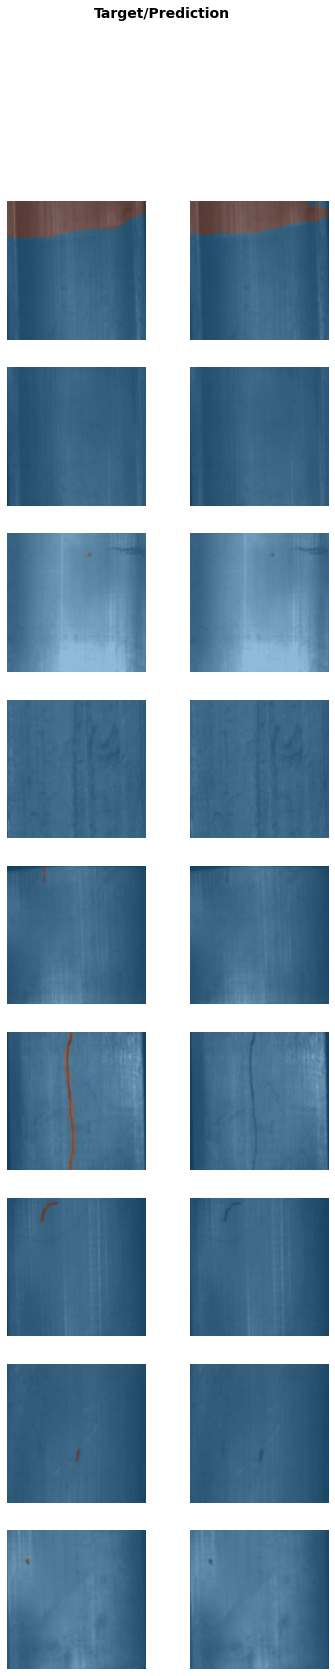

In [ ]:
learn.show_results()

In [ ]:
loss_val, dice_val = learn.validate()
loss_val, dice_val

(0.06269970536231995, 0.9140090046818472)

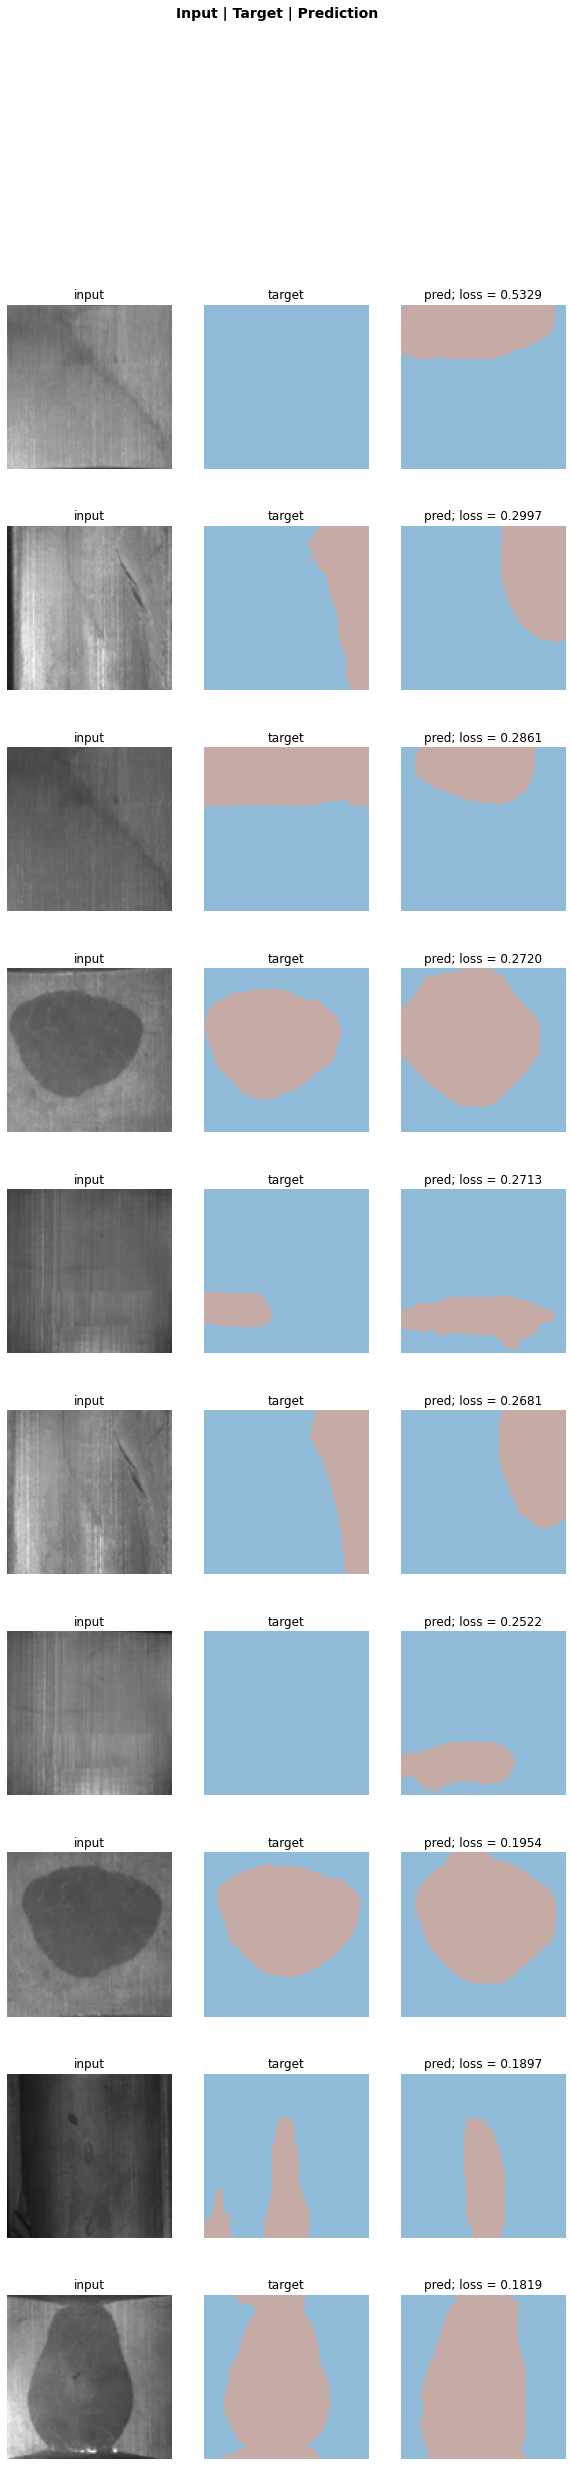

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(10,figsize=(10,40))